# Imports

In [1]:
import robot_plotter as rp
import models_functions as mf
import numpy as np

# Test of functions

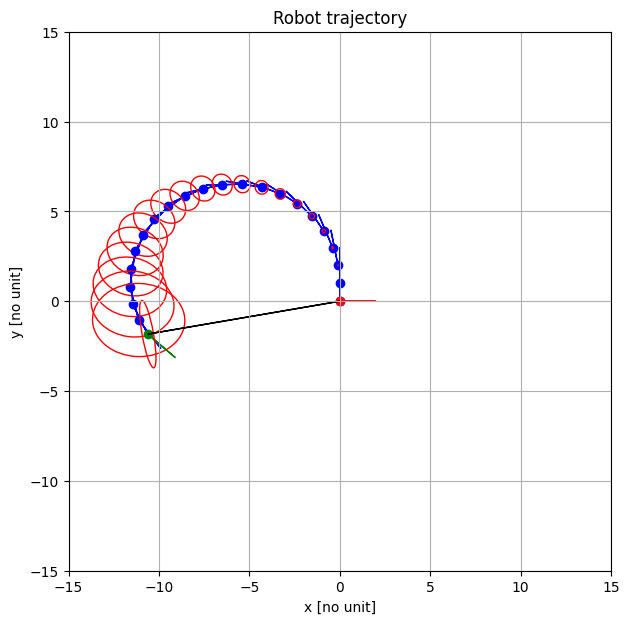

In [2]:
fig, ax = rp.setup_plot()

mmi = mf.MotionModel(x0=np.array([[3.14/2],[0],[0],[0],[0],[1],[0],[0],[0],[0],[0]]), Q=np.diag([0.1, 0.1, 0.1, 0.00001, 0.00001, 0.00001]))
mmj = mf.MotionModel()
measi = mf.MeasModel(R=np.diag([0.1, 0.1, 0.001, 0.001, 0.001]))
measj = mf.MeasModel()

rp.plot_position2(ax, mmi.x, mmi.P)
y = np.array([[0.2], [0], [0.2]])
for i in range(20):
    mmi.predict()
    mmi.propagate()
    mf.KF_IMU(mmi, measi, y)
    rp.plot_position2(ax, mmi.x, mmi.P)

rp.plot_position(ax, mmj.x, color='r')

# Perform correction using anchor
mmi.predict()
mmi.propagate()

yfull = measi.h_full(mmi.x, mmj.x, measj.t)
yfull[mf.Z_W:] = y

mf.KF_full(mmi, mmj, measi, measj, yfull)
rp.plot_position2(ax, mmi.x, mmi.P, color='g')
rp.plot_measurement(ax, mmi.x, mmj.x)